In [1]:
import numpy as np, imp, os, datetime as dt, pandas as pd, matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Path to folder containing wrapper modules
wrapper_fpath = (r"..\inca.py")
optimize_funs_fpath = (r'..\inca_calibration.py')

wr = imp.load_source('inca',wrapper_fpath)
cf = imp.load_source('inca_calibration', optimize_funs_fpath)

### Set up

In [12]:
catchment = 'Morsa' # Choose from: 'Morsa','Tarland'

wr.initialize('simplyp.dll')
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/%s/%sParameters.dat'%(catchment,catchment),
                                                            '../../Applications/SimplyP/%s/%sInputs.dat'%(catchment,catchment))

### Run the model to see what the results look like with manually-calibrated parameters

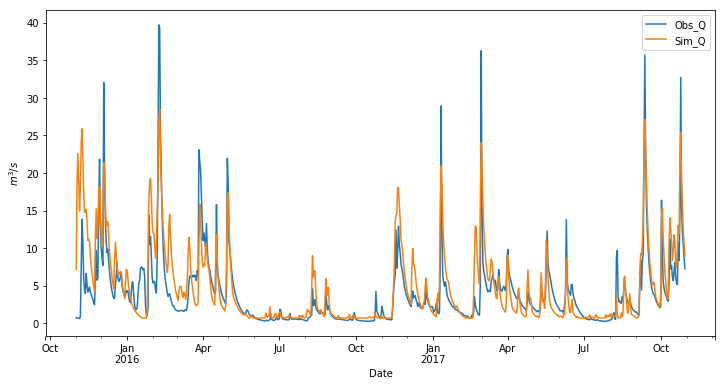

In [13]:
dataset.run_model()

# Read data from the dataset
simQ = dataset.get_result_series('Reach flow (daily mean, cumecs)', ['Kure'])
obsQ = dataset.get_input_series('Observed Q', [], alignwithresults=True)

# simQ = dataset.get_result_series('Reach flow (daily mean, cumecs)', ['Tarland1'])
# obsQ = dataset.get_input_series('observed Q', [], alignwithresults=True)

start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])
unit = dataset.get_result_unit('Reach flow (daily mean, cumecs)')

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_Q': obsQ, 'Sim_Q': simQ})
df.set_index('Date', inplace=True)

# Plot
fig, ax = plt.subplots()
df.plot(figsize=(12,6), ax=ax)
ax.set_ylabel('$%s$' % unit)
plt.show()

In [14]:
comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'], 'Observed Q', []),
              ('Reach TP concentration', ['Kure'], 'Observed TP at Kure', [])]

# comparisons = [('Reach flow (daily mean, cumecs)', ['Tarland1'], 'observed Q', [])]

objective = (0, comparisons, 0)
cf.print_goodness_of_fit(dataset, objective)


Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): 0.747248
Mean absolute error: 2.053867
Mean square error: 11.597068
Nash-Sutcliffe coefficient: 0.531038


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): -0.002641
Mean absolute error: 0.031019
Mean square error: 0.002657
Nash-Sutcliffe coefficient: 0.631092



### Take a look at what is contained in the dataset

In [ ]:
print ('Index sets: %s' %dataset.get_index_sets())
print ('Indices in 1st index set: %s' %dataset.get_indexes(dataset.get_index_sets()[0]))
print ('Indices in 2nd index set: %s' %dataset.get_indexes(dataset.get_index_sets()[1]))

### Reset start date and number of time steps, and realign inputs to new model run period

In [ ]:
# start_date = "1985-01-01"
# timesteps = 760

# dataset.set_parameter_time('Start date', [], start_date)
# dataset.set_parameter_uint('Timesteps',[],timesteps)

# # Align inputs with new start date and time steps
# model_inputs = [i[0] for i in dataset.get_input_list()]
# for variable in model_inputs:
#     series = dataset.get_input_series(variable,[], True)
#     dataset.set_input_series(variable, [], series, True)

### Set up for optimization

Pick out the parameters we want to calibrate, and set initial values for them as well as minimum and maximum limits we want the algorithm to search within.

In [ ]:
paramTupleList = dataset.get_parameter_list()
paramList = [i[0] for i in paramTupleList]
print (paramList)

In [24]:
# Set up from file

# Read in csv with parameters to vary, short names and param ranges
fpath = r'C:\Data\GitHub\INCABuilder\PythonWrapper\SimplyP\SimplyP_calParams_ranges_morsa_v1.csv'
param_df = pd.read_csv(fpath)

# A) Hydrology only

# # List of simulated and observed variables to include in likelihood
# comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'],
#                 'Observed Q', [])]

# # comparisons = [('Reach flow (daily mean, cumecs)', ['Tarland1'], 'observed Q', [])]

# calibration = [
#  ('Initial snow depth as water equivalent', []),
#  ('Degree-day factor for snowmelt', []),
#  ('Proportion of precipitation that contributes to quick flow', []),
#  ('PET multiplication factor', []),
#  ('Soil field capacity', []),
#  ('Baseflow index', []),
#  ('Groundwater time constant', []),
#  ('Minimum groundwater flow', []),
#  ('Gradient of reach velocity-discharge relationship', []),
#  ('Soil water time constant', ['Semi-natural']),
#  ('M_Q', [])
#  ]

# n_vars = len(comparisons)

# initial_guess = cf.default_initial_guess(dataset, calibration[:-n_vars])
# #NOTE: This reads the initial guess that was provided by the parameter file, excluding any error term parameters
# # Initial guess for the residual error term
# initial_guess.append(0.5)

# labels_short = param_df['ShortName']

# # Set upper and lower limits for parameter values
# param_min = list(param_df['Min'].values)
# param_max = list(param_df['Max'].values)

# # param_min = [0.1 * x for x in initial_guess]
# # param_max = [10.0 * x for x in initial_guess]

# cf.constrain_min_max(dataset, calibration, param_min, param_max, n_vars) # NOTE: Constrain to the min and max values recommended
#                                                               # by the model in case we made our bounds too wide.

# labels_long  = ['%s, [%s]' % (cal[0], cal[1]) 
#                     for cal in calibration[:-n_vars]]
# labels_long.append('M_Q')

# -------------------------------------------------------
# B) Hydrology and TP

# List of simulated and observed variables to include in likelihood
comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'],
                'Observed Q', []),
               ('Reach TP concentration', ['Kure'],
               'Observed TP at Kure', [])]

# Make calibration variable (list of (param, index) tuples to calibrate)
# NOTE: Need to automate this, struggling with converting string to list...
calibration = [
 ('Initial snow depth as water equivalent', []),
 ('Degree-day factor for snowmelt', []),
 ('Proportion of precipitation that contributes to quick flow', []),
 ('PET multiplication factor', []),
 ('Soil field capacity', []),
 ('Baseflow index', []),
 ('Groundwater time constant', []),
 ('Minimum groundwater flow', []),
 ('Gradient of reach velocity-discharge relationship', []),
 ('Soil water time constant', ['Semi-natural']),
 ('Reach sediment input scaling factor', []),
 ('Groundwater TDP concentration', []),
 ('Particulate P enrichment factor', []),
 ('Reach effluent TDP inputs', ['Kure']),
 ('Initial soil water TDP concentration and EPC0', ['Arable']),
 ('M_Q', []),
 ('M_TP', [])]

n_vars = len(comparisons)

initial_guess = cf.default_initial_guess(dataset, calibration[:-n_vars])
#NOTE: This reads the initial guess that was provided by the parameter file, excluding any error term parameters
# Initial guess for the residual error term
initial_guess.append(0.5)
initial_guess.append(0.05)

# # Extract inputs
# param_min = list(param_df['Min'].dropna().values)
# param_max = list(param_df['Max'].dropna().values)

# param_min.append(0.05)
# param_min.append(0.005)

# param_max.append(5.0)
# param_max.append(0.5)


param_min = [0.1 * x for x in initial_guess]
param_max = [10.0 * x for x in initial_guess]

labels_short = param_df['ShortName']

labels_long  = ['%s, [%s]' % (cal[0], cal[1]) 
                    for cal in calibration[:-n_vars]]
labels_long.append('M_Q')
labels_long.append('M_TP')

# ###############################
# Same for just hydrol, or hydrol plus P

skiptimesteps = 30   # Skip this many first timesteps in the objective evaluation

objective = (cf.log_likelyhood, comparisons, skiptimesteps)

In [22]:
param_min = list(param_df['Min'].values)
param_max = list(param_df['Max'].values)


param_minB = [0.1 * x for x in initial_guess]
param_maxB = [10.0 * x for x in initial_guess]

# print(param_min)
print(param_minB)

# print(param_max)
print(param_maxB)

[5.0, 0.274, 0.0020000000000000005, 0.07, 20.0, 0.05, 1.0, 0.020000000000000004, 0.05, 0.30000000000000004, 1100.0, 0.0010000000000000002, 0.15000000000000002, 0.2, 0.030000000000000006, 0.05, 0.005000000000000001]
[500.0, 27.400000000000002, 0.20000000000000004, 7.000000000000001, 2000.0, 5.0, 100.0, 2.0, 5.0, 30.0, 110000.0, 0.10000000000000002, 15.0, 20.0, 3.0000000000000004, 5.0, 0.5]


In [ ]:
# # Set up manually here rather than from file

# # comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'], 'Observed Q', []),
# #               ('Reach TP concentration', ['Kure'], 'Observed TP at Kure', [])]

# comparisons = [('Reach flow (daily mean, cumecs)', ['Tarland1'], 'observed Q', [])]

# n_vars = len(comparisons)

# #NOTE: The 'calibration' structure is a list of (indexed) parameters that we want to calibrate
# calibration = [
#     ('Initial snow depth as water equivalent',                      []),
#     ('Degree-day factor for snowmelt',                             []),
#     ('Proportion of precipitation that contributes to quick flow', []),
#     ('PET multiplication factor',                                       []),
#     ('Baseflow index',                                             []),
#     ('Groundwater time constant',                                  []),
#     ('Gradient of reach velocity-discharge relationship',         []),
# #     ('Soil water time constant',                                   ['Arable']),
#     ('Soil water time constant',                                   ['Semi-natural']),
#     ('Soil field capacity',                                        []),
#     ('Minimum groundwater flow',                                   []),
#     ('M_Q', [])
#     ]

# # calibration = [('Degree-day factor for snowmelt', []),
# #  ('Proportion of precipitation that contributes to quick flow', []),
# #  ('PET multiplication factor', []),
# #  ('Soil field capacity', []),
# #  ('Baseflow index', []),
# #  ('Groundwater time constant', []),
# #  ('Minimum groundwater flow', []),
# #  ('Gradient of reach velocity-discharge relationship', []),
# #  ('Soil water time constant', ['Semi-natural']),
# #  ('Reach sediment input scaling factor', []),
# #  ('Groundwater TDP concentration', []),
# #  ('Particulate P enrichment factor', []),
# #  ('Reach effluent TDP inputs', ['Kure']),
# #  ('Initial soil water TDP concentration and EPC0', ['Arable']),
# #  ('M_Q', []),
# #  ('M_TP', [])]

# # Read the initial guess provided by the parameter file
# initial_guess = cf.default_initial_guess(dataset, calibration[:-n_vars])

# # Initial guess for the residual error term
# initial_guess.append(0.5)
# # initial_guess.append(0.05)

# # Set upper and lower limits for parameter values
# param_min = [0.1 * x for x in initial_guess]
# param_max = [10.0 * x for x in initial_guess]

# cf.constrain_min_max(dataset, calibration, param_min, param_max, n_vars) # NOTE: Constrain to the min and max values recommended
#                                                               # by the model in case we made our bounds too wide.

# skiptimesteps = 30   # Skip these many of the first timesteps in the objective evaluation

# objective = (cf.log_likelyhood, comparisons, skiptimesteps)

### Run the optimizer and print the results

In [25]:
%%time
param_est = cf.run_optimization(dataset, param_min, param_max, initial_guess, calibration, objective, minimize=False)
#param_est = param_est[0]

Optimization terminated successfully.
         Current function value: 1664.910291
         Iterations: 6739
         Function evaluations: 9553
Wall time: 3min 57s


In [ ]:
for idx, cal in enumerate(calibration) :
    name, indexes = cal
    print('Estimated %-60s %-20s %5.2f (range [%5.2f, %5.2f])' %  (name, ', '.join(indexes),
                                                                   param_est[idx],
                                                                   param_min[idx], param_max[idx]))
if len(param_est) > len(calibration) :
    print('M: %f' % param_est[len(calibration)])

### Save the optimized parameter values

Write the optimal values back to the dataset, and then generate a new parameter file that has these values

In [ ]:
cf.set_values(dataset, param_est, calibration[:-n_vars])
# dataset.write_parameters_to_file('optimal_parameters.dat')

### Run with optimal parameters and plot

Run the model one more time with the optimal parameters and plot simulated output. Save figure to file, and optionally display it here too.

In [ ]:
dataset.run_model()
fig, ax = cf.plot_objective(dataset, objective, "simplyp_plots\\Morsa_optimizer_MAP.png", return_fig=True)
plt.show()

In [ ]:
dataset.run_model()

# Read data from the dataset
sim = dataset.get_result_series('Reach TP concentration', ['Kure'])
obs = dataset.get_input_series('Observed TP at Kure', [], alignwithresults=True)
start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_TP': obs, 'Sim_TP': sim})
df.set_index('Date', inplace=True)

# Plot
fig, ax = plt.subplots()
df.Obs_TP.plot(marker='o', ax=ax)
df.plot(figsize=(12,6), ax=ax)
ax.set_ylabel('TP concentration')
plt.show()

# comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'], 'Observed Q', []),
#               ('Reach TP concentration', ['Kure'], 'Observed TP at Kure', [])]
# objective = (0,comparisons, 0)
cf.print_goodness_of_fit(dataset, objective)

In [ ]:
# Work out annual sums of simulated and observed specific Q

# Read data from the dataset
simQ = dataset.get_result_series('Reach flow (daily mean, cumecs)', ['Kure'])
obsQ = dataset.get_input_series('Observed Q', [], alignwithresults=True)
start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_Q': obsQ, 'Sim_Q': simQ})
df.set_index('Date', inplace=True)

df_annualSums = df.groupby(df.index.year).sum()
df_annualSums['Sim_specificQ'] = df_annualSums.Sim_Q * 86400 * 10**-3 / 304.65
df_annualSums['Obs_specificQ'] = df_annualSums.Obs_Q * 86400 * 10**-3 / 304.65

df_annualSums

In [ ]:
dataset.delete()